# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

cancer = load_breast_cancer()

df_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)


# selecionando features

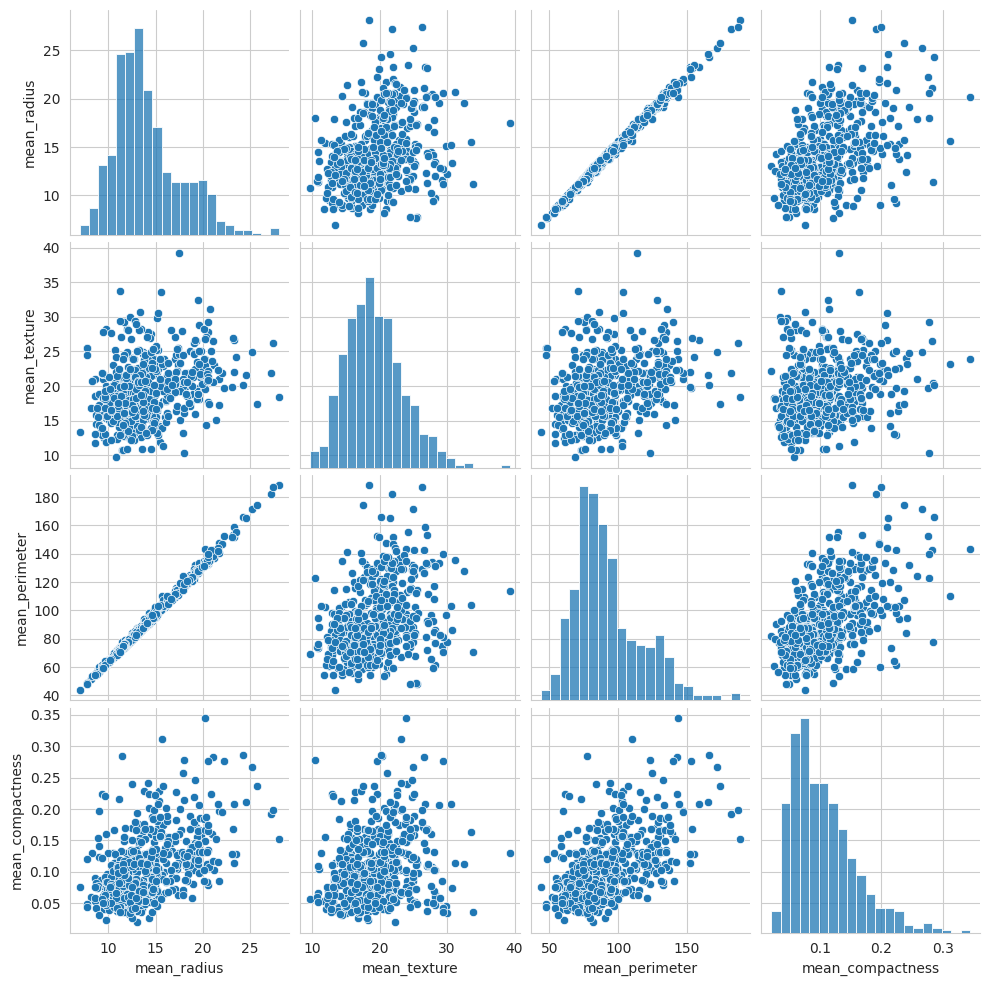

In [17]:

y_regressao = 'mean area'

df_regressao = df_cancer.copy()
df_regressao['Y'] = df_regressao[y_regressao]
df_regressao = df_regressao.drop(columns=[y_regressao])


df_regressao.columns = df_regressao.columns.str.replace(' ', '_')
features_independentes_exemplo = ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_compactness']

seaborn.pairplot(df_regressao, vars=features_independentes_exemplo)

# Regressão progressiva e KNN

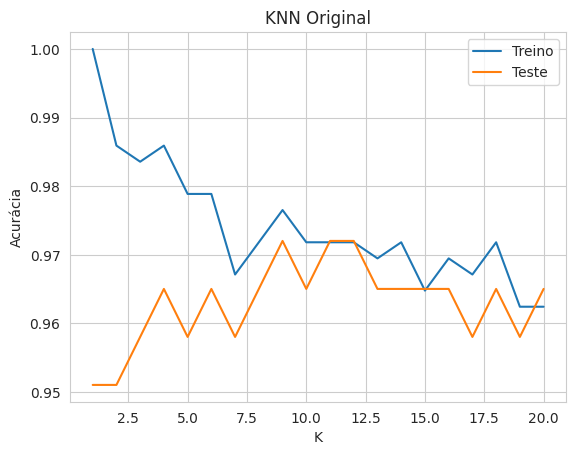

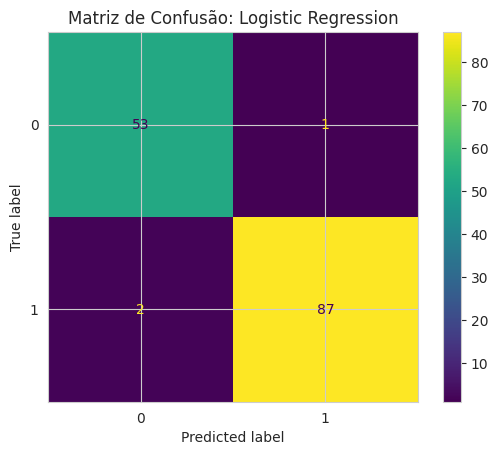

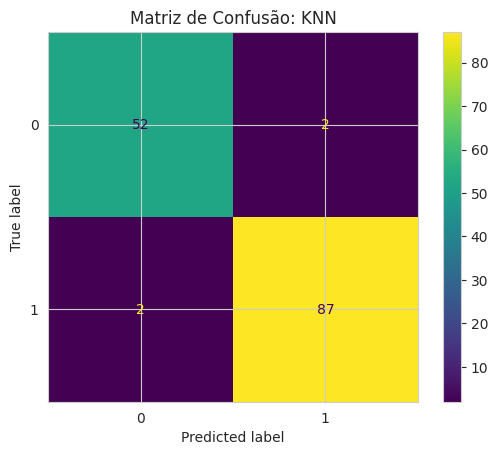

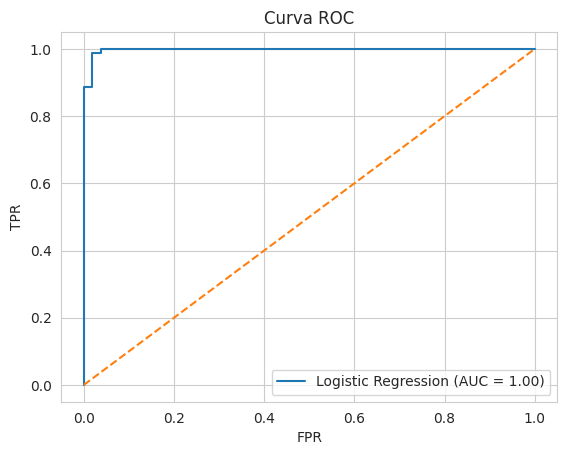

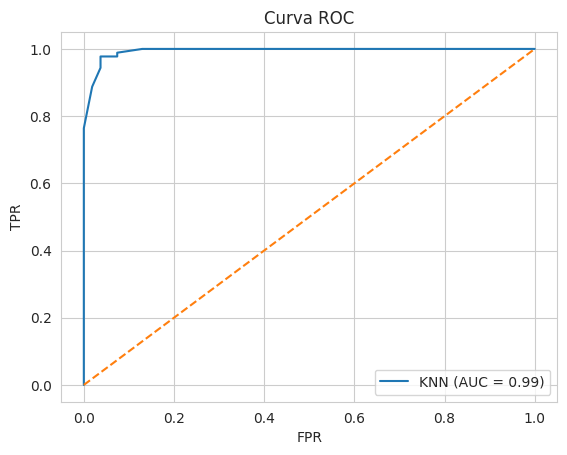

,Holdout,CrossVal
acc_logreg,0.979021,0.950800
prec_logreg,0.988636,0.954262
rec_logreg,0.977528,0.969210
f1_logreg,0.983051,0.961188
acc_knn,0.972028,0.931470
prec_knn,0.977528,0.929497
rec_knn,0.977528,0.966315
f1_knn,0.977528,0.946830


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)

def carrega_dados():
    data = load_breast_cancer()
    return pd.DataFrame(data.data, columns=data.feature_names), data.target

def separa_dados(X, y):
    return train_test_split(X, y, test_size=0.25, random_state=42)

def padroniza(X_train, X_test):
    s = StandardScaler()
    return s.fit_transform(X_train), s.transform(X_test)

def aumenta_ruido(X, y):
    r = np.random.normal(0, 0.1, X.shape)
    return np.concatenate([X, X + r]), np.concatenate([y, y])

def monta_logreg():
    return LogisticRegression(max_iter=10000)

def monta_knn(k):
    return KNeighborsClassifier(n_neighbors=k)

def avalia_holdout(modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None
    return {
        "acc": accuracy_score(y_test, y_pred),
        "prec": precision_score(y_test, y_pred),
        "rec": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "y_pred": y_pred,
        "y_proba": y_proba
    }

def avalia_crossval(modelo, X, y):
    r = cross_validate(modelo, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1"])
    return {k: v.mean() for k, v in r.items() if "test" in k}

def plota_matriz(y_true, y_pred, nome):
    d = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    d.plot()
    plt.title(f"Matriz de Confusão: {nome}")
    plt.show()

def plota_roc(y_true, y_proba, nome):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nome} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Curva ROC")
    plt.legend()
    plt.grid(True)
    plt.show()

def compara_knn(X_train, X_test, y_train, y_test, titulo):
    acctrain, acctest = [], []
    ks = range(1, 21)
    for k in ks:
        m = monta_knn(k)
        m.fit(X_train, y_train)
        acctrain.append(m.score(X_train, y_train))
        acctest.append(m.score(X_test, y_test))
    plt.plot(ks, acctrain, label="Treino")
    plt.plot(ks, acctest, label="Teste")
    plt.title(titulo)
    plt.xlabel("K")
    plt.ylabel("Acurácia")
    plt.legend()
    plt.grid(True)
    plt.show()
    return ks[np.argmax(acctest)]

X, y = carrega_dados()
X_train, X_test, y_train, y_test = separa_dados(X, y)
X_train_s, X_test_s = padroniza(X_train, X_test)
X_aug, y_aug = aumenta_ruido(X_train_s, y_train)

logreg = monta_logreg()
knn_k = compara_knn(X_train_s, X_test_s, y_train, y_test, "KNN Original")
knn = monta_knn(knn_k)

res_logreg = avalia_holdout(logreg, X_train_s, X_test_s, y_train, y_test)
res_knn = avalia_holdout(knn, X_train_s, X_test_s, y_train, y_test)

plota_matriz(y_test, res_logreg["y_pred"], "Logistic Regression")
plota_matriz(y_test, res_knn["y_pred"], "KNN")

plota_roc(y_test, res_logreg["y_proba"], "Logistic Regression")
plota_roc(y_test, res_knn["y_proba"], "KNN")

res_cv_logreg = avalia_crossval(monta_logreg(), X, y)
res_cv_knn = avalia_crossval(monta_knn(knn_k), X, y)

pd.DataFrame({
    "Holdout": {
        "acc_logreg": res_logreg["acc"],
        "prec_logreg": res_logreg["prec"],
        "rec_logreg": res_logreg["rec"],
        "f1_logreg": res_logreg["f1"],
        "acc_knn": res_knn["acc"],
        "prec_knn": res_knn["prec"],
        "rec_knn": res_knn["rec"],
        "f1_knn": res_knn["f1"]
    },
    "CrossVal": {
        "acc_logreg": res_cv_logreg["test_accuracy"],
        "prec_logreg": res_cv_logreg["test_precision"],
        "rec_logreg": res_cv_logreg["test_recall"],
        "f1_logreg": res_cv_logreg["test_f1"],
        "acc_knn": res_cv_knn["test_accuracy"],
        "prec_knn": res_cv_knn["test_precision"],
        "rec_knn": res_cv_knn["test_recall"],
        "f1_knn": res_cv_knn["test_f1"]
    }
})
